# Getting Started with PDF QnA using LangChain 🦜️🔗 + Vertex AI PaLM API 

Self Lik: go/workbench-bq-langchain-vertex-genai

| | |
|----------|-------------|
| Author(s)   | Sagar Kewalramani (skewalramani@) |



Credits : 
References from Rajesh Thallam (rthallam@)


## Objective
This notebook provides an introductory understanding of [Langchain]((https://langchain.com/)) components and use cases of LangChain with BigQuery & Vertex PaLM APIs.

- ✅ Introduce LangChain components
- ✅ Showcase LangChain +   Vertex PaLM API - Text
- ✅ Question/Answering on PDF Files (retrieval based)

---

**References:**

- Adapted from [LangChain Cookbook](https://github.com/gkamradt/langchain-tutorials) from [Greg Kamradt](https://twitter.com/GregKamradt)
- [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)
- [LangChain Python Documentation](https://python.langchain.com/en/latest/)


PATH = get_ipython().run_line_magic("env", "PATH")
%env PATH={PATH}:/home/jupyter/.local/bin### **What is LangChain?**
> LangChain is a framework for developing applications powered by language models.

**TL;DR** LangChain makes the complicated parts of working & building with AI models easier. It helps do this in two ways:

1. **Integration** - Bring external data, such as your files, other applications, and api data, to your LLMs
2. **Agents** - Allow your LLMs to interact with it's environment via decision making. Use LLMs to help decide which action to take next


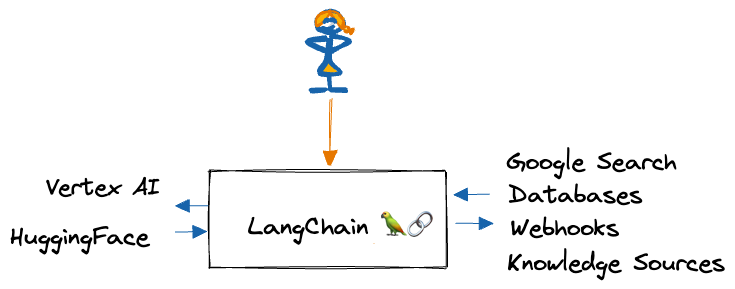


Often times, you may want to augment LLMs with external data sources and make decisions based on outputs of LLMs. Here are a few - like calling SQL after we asked LLM to generate a SQL based on text, or call a webhook/API based on response, or synthesize outputs from multiple LLM calls, or call LLMs in a specific order. It may look trivial to plumb these API calls together and orchestrate them but it gets boring to write glue code again e.g. for every different data connector or LLM. That’s where LangChain comes in. Its modular implementation and common patterns combining these components make it easier to build complex applications based on LLMs.

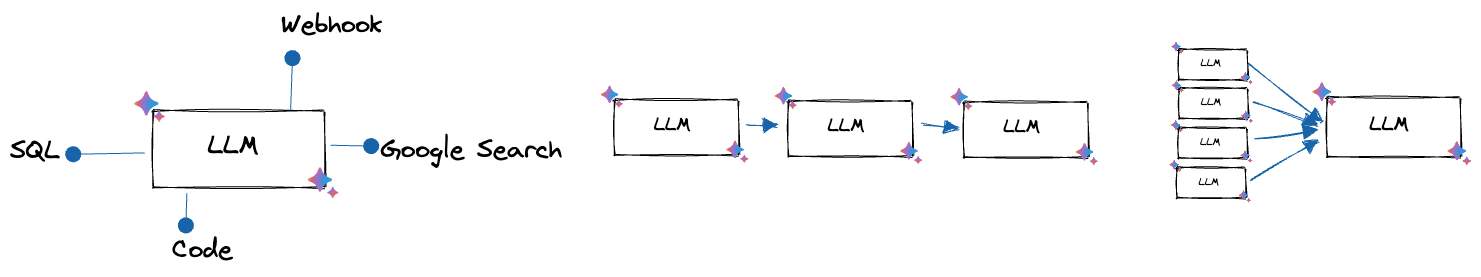

### **Why LangChain?**
1. **Components** - LangChain makes it easy to swap out abstractions and components necessary to work with language models.

2. **Customized Chains** - LangChain provides out of the box support for using and customizing 'chains' - a series of actions strung together.

3. **Speed 🚢** - This team ships insanely fast. You'll be up to date with the latest LLM features.

4. **Community 👥** - Wonderful discord and community support, meet ups, hackathons, etc.

Though LLMs can be straightforward (text-in, text-out) you'll quickly run into friction points that LangChain helps with once you develop more complicated applications.

*Note: This notebook does not cover all aspects of LangChain. It's contents have been curated to get you to building & impact as quick as possible. For more, please check out [LangChain Conceptual Documentation](https://docs.langchain.com/docs/)*

In [ ]:
PATH = get_ipython().run_line_magic("env", "PATH")
%env PATH={PATH}:/home/jupyter/.local/bin

# Install Vertex AI LLM SDK

In [ ]:

! pip install --user --quiet google-cloud-aiplatform==1.25.0

# Install pandas
! pip install --user --quiet pandas

# Install HuggingFace Datasets
! pip install --user --quiet datasets

# Install Python client for Google Search API
! pip install --user --quiet google-api-python-client

# PDF loader
! pip install --user --quiet pypdf

# Install similarity search library
# TO-DO: Replace with vertex AI Matching Engine
! pip install --user --quiet faiss-cpu

# Install LangChain & SQL Alchemy
### LangChain is an open source frameowrk that allows AI developers to combine LLM like PaLM with external sources of computation and data
### SQLAlchemy is an open-source SQL toolkit and object-relational mapper for the Python programming language released under the MIT License.
### Gradio is an open-source Python library that is used to build machine learning and data science demos and web applications.

In [ ]:
# Install Python Libraries
!pip install --user chromadb --quiet
!pip install --user langchain==0.0.157 --quiet
!pip install --user google-cloud-core --quiet
!pip install --user gradio --quiet

# Below libraries are required to build a SQL engine for BigQuery
!pip install --user SQLAlchemy==1.4.48 --quiet
!pip install --user sqlalchemy-bigquery --quiet

In [ ]:
!pip freeze | grep SQLAlchemy


In [ ]:
# Load necessary libraries
import os
if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---

#### ⚠️ Do not forget to "RESTART RUNTIME" 

---

In [ ]:
PROJECT_ID = "analytics-ml-ai"  # @param {type:"string"}
LOCATION = "us-central1" # @param {type:"string"}

---

#### ⚠️ Do not forget to update the PROJECT_ID to your project

---

# LangChain Components

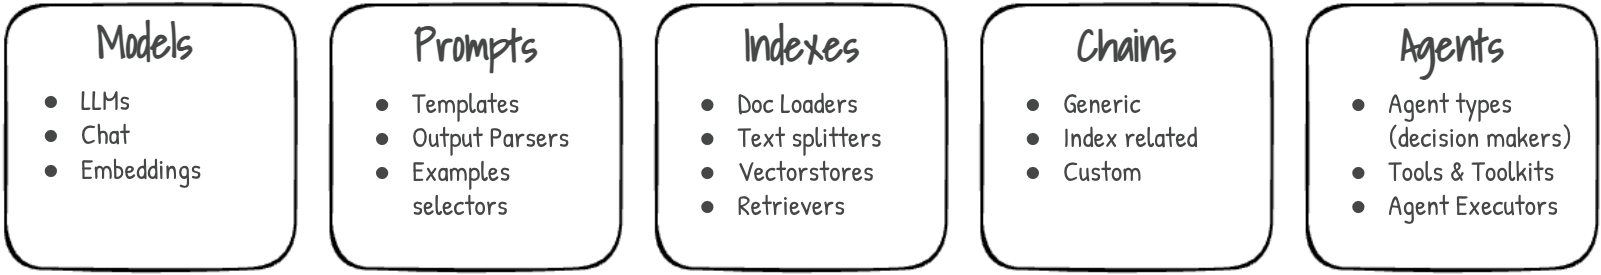

In [ ]:
import langchain
print(f"LangChain version: {langchain.__version__}")

from google.cloud import aiplatform
print(f"Vertex AI SDK version: {aiplatform.__version__}")

# Initialize Vertex AI SDK
import vertexai
vertexai.init(project=PROJECT_ID, location=LOCATION)

# Vertex AI LLM wrapper for using with Langchain
# 04/19: Eventually this wrapper will be replaced by official Langchain + Vertex AI integration

In [ ]:


import time
from typing import Any, Mapping, List, Dict, Optional, Tuple, Union
from dataclasses import dataclass, field

from pydantic import BaseModel, Extra, root_validator

from langchain.llms.base import LLM
from langchain.embeddings.base import Embeddings
from langchain.chat_models.base import BaseChatModel
from langchain.llms.utils import enforce_stop_tokens
from langchain.schema import Generation, LLMResult
from langchain.schema import AIMessage, BaseMessage, ChatGeneration, ChatResult, HumanMessage, SystemMessage

from vertexai.preview.language_models import TextGenerationResponse, ChatSession


def rate_limit(max_per_minute):
  period = 60 / max_per_minute
  print('Waiting')
  while True:
    before = time.time()
    yield
    after = time.time()
    elapsed = after - before
    sleep_time = max(0, period - elapsed)
    if sleep_time > 0:
      print('.', end='')
      time.sleep(sleep_time)


class _VertexCommon(BaseModel):
    """Wrapper around Vertex AI large language models.

    To use, you should have the
    ``google.cloud.aiplatform.private_preview.language_models`` python package
    installed.
    """
    client: Any = None #: :meta private:
    model_name: str = "text-bison@001"
    """Model name to use."""

    temperature: float = 0.2
    """What sampling temperature to use."""

    top_p: int = 0.8
    """Total probability mass of tokens to consider at each step."""

    top_k: int = 40
    """The number of highest probability tokens to keep for top-k filtering."""

    max_output_tokens: int = 200
    """The maximum number of tokens to generate in the completion."""

    @property
    def _default_params(self) -> Mapping[str, Any]:
        """Get the default parameters for calling Vertex AI API."""
        return {
            "temperature": self.temperature,
            "top_p": self.top_p,
            "top_k": self.top_k,
            "max_output_tokens": self.max_output_tokens
        }

    def _predict(self, prompt: str, stop: Optional[List[str]]) -> str:
        res = self.client.predict(prompt, **self._default_params)
        return self._enforce_stop_words(res.text, stop)

    def _enforce_stop_words(self, text: str, stop: Optional[List[str]]) -> str:
        if stop:
            return enforce_stop_tokens(text, stop)
        return text

    @property
    def _llm_type(self) -> str:
        """Return type of llm."""
        return "vertex_ai"

class VertexLLM(_VertexCommon, LLM):
    model_name: str = "text-bison@001"

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import TextGenerationModel
        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["client"] = TextGenerationModel.from_pretrained(values["model_name"])
        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    def _call(self, prompt: str, stop: Optional[List[str]] = None) -> str:
        """Call out to Vertex AI's create endpoint.

        Args:
            prompt: The prompt to pass into the model.

        Returns:
            The string generated by the model.
        """
        return self._predict(prompt, stop)


@dataclass
class _MessagePair:
    """InputOutputTextPair represents a pair of input and output texts."""

    question: HumanMessage
    answer: AIMessage


@dataclass
class _ChatHistory:
    """InputOutputTextPair represents a pair of input and output texts."""

    history: List[_MessagePair] = field(default_factory=list)
    system_message: Optional[SystemMessage] = None


def _parse_chat_history(history: List[BaseMessage]) -> _ChatHistory:
    """Parses a sequence of messages into history.

    A sequency should be either (SystemMessage, HumanMessage, AIMessage,
    HumanMessage, AIMessage, ...) or (HumanMessage, AIMessage, HumanMessage,
    AIMessage, ...).
    """
    if not history:
        return _ChatHistory()
    first_message = history[0]
    system_message = first_message if isinstance(first_message, SystemMessage) else None
    chat_history = _ChatHistory(system_message=system_message)
    messages_left = history[1:] if system_message else history
    # if len(messages_left) % 2 != 0:
    #     raise ValueError(
    #         f"Amount of messages in history should be even, got {len(messages_left)}!"
    #     )
    for question, answer in zip(messages_left[::2], messages_left[1::2]):
        if not isinstance(question, HumanMessage) or not isinstance(answer, AIMessage):
            raise ValueError(
                "A human message should follow a bot one, "
                f"got {question.type}, {answer.type}."
            )
        chat_history.history.append(_MessagePair(question=question, answer=answer))
    return chat_history


class _VertexChatCommon(_VertexCommon):
    """Wrapper around Vertex AI Chat large language models.

    To use, you should have the
    ``vertexai.preview.language_models`` python package
    installed.
    """
    model_name: str = "chat-bison@001"
    """Model name to use."""

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import ChatModel
        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["client"] = ChatModel.from_pretrained(values["model_name"])
        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    def _response_to_chat_results(
        self, response: TextGenerationResponse, stop: Optional[List[str]]
    ) -> ChatResult:
        text = self._enforce_stop_words(response.text, stop)
        return ChatResult(generations=[ChatGeneration(message=AIMessage(content=text))])


class VertexChat(_VertexChatCommon, BaseChatModel):
    """Wrapper around Vertex AI large language models.

    To use, you should have the
    ``vertexai.preview.language_models`` python package
    installed.
    """

    model_name: str = "chat-bison@001"
    chat: Any = None  #: :meta private:

    def send_message(
        self, message: Union[HumanMessage, str], stop: Optional[List[str]] = None
    ) -> ChatResult:
        text = message.content if isinstance(message, BaseMessage) else message
        response = self.chat.send_message(text)
        text = self._enforce_stop_words(response.text, stop)
        return ChatResult(generations=[ChatGeneration(message=AIMessage(content=text))])

    def _generate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        if not messages:
            raise ValueError(
                "You should provide at least one message to start the chat!"
            )
        question = messages[-1]
        if not isinstance(question, HumanMessage):
            raise ValueError(
                f"Last message in the list should be from human, got {question.type}."
            )
        self.start_chat(messages[:-1])
        return self.send_message(question)

    def start_chat(self, messages: List[BaseMessage]) -> None:
        """Starts a chat."""
        history = _parse_chat_history(messages)
        context = history.system_message.content if history.system_message else None
        self.chat = self.client.start_chat(context=context, **self._default_params)
        for pair in history.history:
            self.chat._history.append((pair.question.content, pair.answer.content))

    def clear_chat(self) -> None:
        self.chat = None

    @property
    def history(self) -> List[BaseMessage]:
        """Chat history."""
        history: List[BaseMessage] = []
        if self.chat:
            for question, answer in self.chat._history:
                history.append(HumanMessage(content=question))
                history.append(AIMessage(content=answer))
        return history

    async def _agenerate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        raise NotImplementedError(
            """Vertex AI doesn't support async requests at the moment."""
        )

class VertexMultiTurnChat(_VertexChatCommon, BaseChatModel):
    """Wrapper around Vertex AI large language models."""

    model_name: str = "chat-bison@001"
    chat: Optional[ChatSession] = None

    def clear_chat(self) -> None:
        self.chat = None

    def start_chat(self, message: Optional[SystemMessage] = None) -> None:
        if self.chat:
            raise ValueError("Chat has already been started. Please, clear it first.")
        if message and not isinstance(message, SystemMessage):
            raise ValueError("Context should be a system message")
        context = message.content if message else None
        self.chat = self.client.start_chat(context=context, **self._default_params)

    @property
    def history(self) -> List[Tuple[str]]:
        """Chat history."""
        if self.chat:
            return self.chat._history
        return []

    def _generate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        if len(messages) != 1:
            raise ValueError(
                "You should send exactly one message to the chat each turn."
            )
        if not self.chat:
            raise ValueError("You should start_chat first!")
        response = self.chat.send_message(messages[0].content)
        return self._response_to_chat_results(response, stop=stop)

    async def _agenerate(
        self, messages: List[BaseMessage], stop: Optional[List[str]] = None
    ) -> ChatResult:
        raise NotImplementedError(
            """Vertex AI doesn't support async requests at the moment."""
        )

class VertexEmbeddings(Embeddings, BaseModel):
    """Wrapper around Vertex AI large language models embeddings API.

    To use, you should have the
    ``google.cloud.aiplatform.private_preview.language_models`` python package
    installed.
    """
    model_name: str = "textembedding-gecko@001"
    """Model name to use."""

    model: Any
    requests_per_minute: int = 15


    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that the python package exists in environment."""
        try:
            from vertexai.preview.language_models import TextEmbeddingModel

        except ImportError:
            raise ValueError(
                "Could not import Vertex AI LLM python package. "
            )

        try:
            values["model"] = TextEmbeddingModel

        except AttributeError:
            raise ValueError(
                "Could not set Vertex Text Model client."
            )

        return values

    class Config:
        """Configuration for this pydantic object."""

        extra = Extra.forbid

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
      """Call Vertex LLM embedding endpoint for embedding docs
      Args:
          texts: The list of texts to embed.
      Returns:
          List of embeddings, one for each text.
      """
      self.model = self.model.from_pretrained(self.model_name)

      limiter = rate_limit(self.requests_per_minute)
      results = []
      docs = list(texts)

      while docs:
        # Working in batches of 2 because the API apparently won't let
        # us send more than 2 documents per request to get embeddings.
        head, docs = docs[:2], docs[2:]
        # print(f'Sending embedding request for: {head!r}')
        chunk = self.model.get_embeddings(head)
        results.extend(chunk)
        next(limiter)

      return [r.values for r in results]

    def embed_query(self, text: str) -> List[float]:
      """Call Vertex LLM embedding endpoint for embedding query text.
      Args:
        text: The text to embed.
      Returns:
        Embedding for the text.
      """
      single_result = self.embed_documents([text])
      return single_result[0]

In [ ]:
REQUESTS_PER_MINUTE = 100

llm = VertexLLM(
    model_name='text-bison@001',
    max_output_tokens=256,
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    verbose=True,
)

chat = VertexChat()

mchat = VertexMultiTurnChat(max_output_tokens=1024)

embedding = VertexEmbeddings(requests_per_minute=REQUESTS_PER_MINUTE)

# Question/Answering Chain

Easily do QA over a set of documents using QA chain. There are multiple ways to do this with LangChain. We use **RetrievalQA** chain actually uses **load_qa_chain** under the hood.

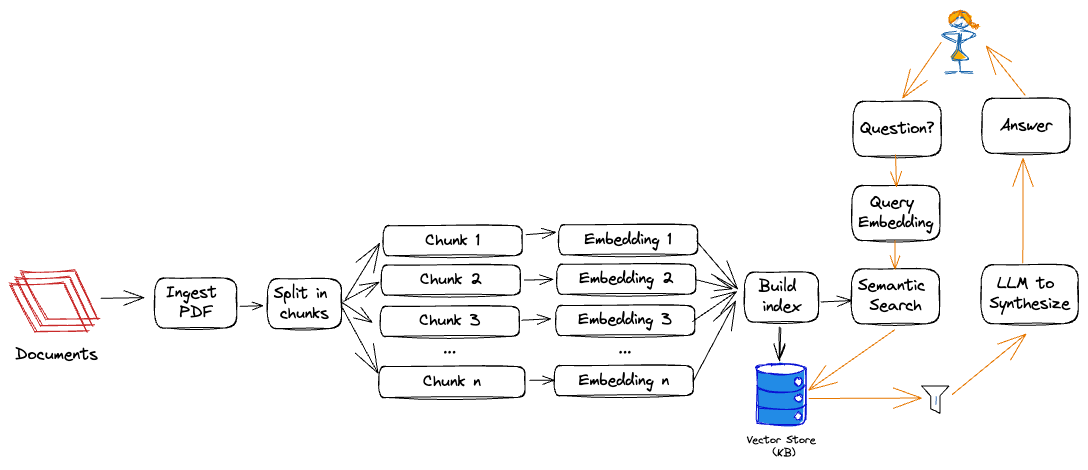

In [ ]:
# Ingest PDF files
from langchain.document_loaders import PyPDFLoader

# Load GOOG's 10K annual report (92 pages).
url = "https://abc.xyz/assets/9a/bd/838c917c4b4ab21f94e84c3c2c65/goog-10-k-q4-2022.pdf"
loader = PyPDFLoader(url)
documents = loader.load()

In [ ]:
# split the documents into chunks
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)
print(f"# of documents = {len(docs)}")

In [ ]:
# select embedding engine - we use Vertex PaLM Embeddings API
embedding

In [ ]:
# Store docs in local vectorstore as index
# it may take a while since API is rate limited
from langchain.vectorstores import Chroma

db = Chroma.from_documents(docs, embedding)

In [ ]:
# Expose index to the retriever
retriever = db.as_retriever(
    search_type="similarity",
    search_kwargs={"k":2})

In [ ]:
# Create chain to answer questions
from langchain.chains import RetrievalQA

# Uses LLM to synthesize results from the search index.
# We use Vertex PaLM Text API for LLM
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True)

In [15]:
query = "What was Alphabet's net income in 2022?"
result = qa({"query": query})
print(result)

Waiting
{'query': "What was Alphabet's net income in 2022?", 'result': "Alphabet's net income in 2022 was $59,972.", 'source_documents': [Document(page_content='Alphabet Inc.\nCONSOLIDATED STATEMENTS OF INCOME\n(in millions, except per share amounts)\n Year Ended December 31,\n 2020 2021 2022\nRevenues $ 182,527 $ 257,637 $ 282,836 \nCosts and expenses:\nCost of revenues  84,732  110,939  126,203 \nResearch and development  27,573  31,562  39,500 \nSales and marketing  17,946  22,912  26,567 \nGeneral and administrative  11,052  13,510  15,724 \nTotal costs and expenses  141,303  178,923  207,994 \nIncome from operations  41,224  78,714  74,842 \nOther income (expense), net  6,858  12,020  (3,514) \nIncome before income taxes  48,082  90,734  71,328 \nProvision for income taxes  7,813  14,701  11,356 \nNet income $ 40,269 $ 76,033 $ 59,972 \nBasic net income per share of Class A, Class B, and Class C stock $ 2.96 $ 5.69 $ 4.59 \nDiluted net income per share of Class A, Class B, and Cla

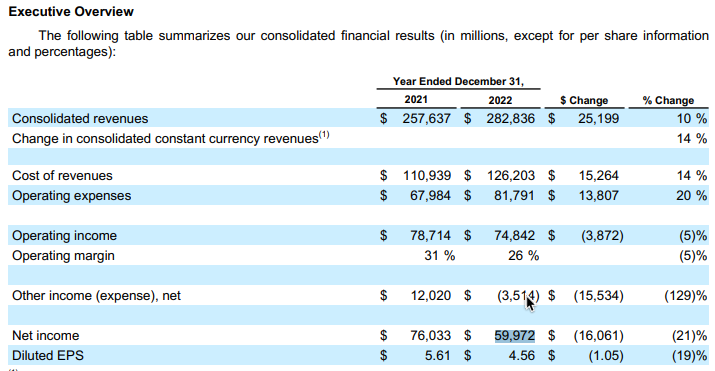

In [16]:
query = "How much office space reduction took place in 2023?"
result = qa({"query": query})
print(result)

Waiting
{'query': 'How much office space reduction took place in 2023?', 'result': 'The office space reduction was approximately $0.5 billion in the first quarter of 2023.', 'source_documents': [Document(page_content='incur employee severance and related charges of $1.9 billion  to $2.3 billion , the majority of which will be recognized in \nthe first quarter of 2023.\nIn addition, we are taking actions to optimize our global office space. As a result we expect to incur exit costs \nrelating to office space reductions of approximately $0.5 billion  in the first quarter of 2023.  We may incur additional \ncharges in the future as we further evaluate our real estate needs. Table of Contents Alphabet Inc.\n83', metadata={'source': '/var/tmp/tmpa3lbegvu', 'page': 83}), Document(page_content='Note 11  of the Notes to Consolidated Financial Statements included in Item 8 of this Annual Report on Form \n10-K for additional information.\n•Operating cash flow was $91.5 billion  for the year ende

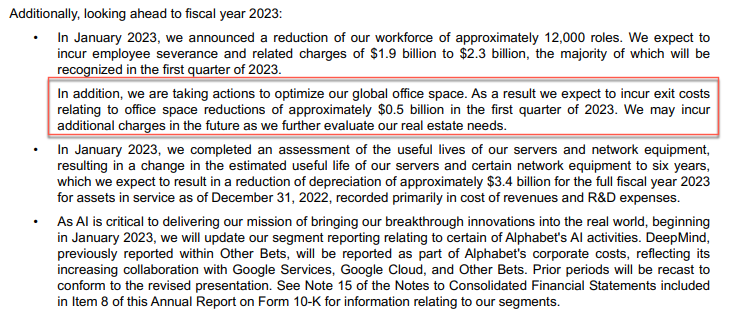